# Ragone plot

This notebook shows how to generate a Ragone plot, based on the stack thickness and stack density. The procedure is from the "[rate-capability](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/rate-capability.ipynb)" notebook - check out the many other [example notebooks](https://github.com/pybamm-team/PyBaMM/tree/develop/docs/source/examples/notebooks) from PyBaMM to estimate more cell metrics with simulations.

In [1]:
# %pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
# !pip install git+https://github.com/pybamm-team/pybamm-tea.git # install PyBaMM-TEA if it is not installed
import pybamm
import pybamm_tea
import numpy as np
import matplotlib.pyplot as plt

_In this example we use the SPMe model with the default settings, but we could change it to other models, parameters, geometries... For example, you generate rate capability plots using the DFN model in [this script](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/scripts/rate_capability.py)._

Also we use the TEA class to relate the energy and power to the stack mass.

In [2]:
model = pybamm.lithium_ion.SPMe()

# set up the TEA class
input = {"Electrolyte density [kg.m-3]": 1276}
base = pybamm.ParameterValues("Chen2020")
tea_class = pybamm_tea.TEA(base, input)

C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:138: UserWarning: Warning: 'Negative electrode active material density [kg.m-3]' and 'Negative electrode dry density [kg.m-3]' have been calulated from;'Electrolyte density [kg.m-3]', 'Negative electrode porosity' and 'Negative electrode density [kg.m-3]'
  warnings.warn(
C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:138: UserWarning: Warning: 'Positive electrode active material density [kg.m-3]' and 'Positive electrode dry density [kg.m-3]' have been calulated from;'Electrolyte density [kg.m-3]', 'Positive electrode porosity' and 'Positive electrode density [kg.m-3]'
  warnings.warn(
C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:329: UserWarning: Warning: 'Initial loss of lithium inventory' is set to 0.
  warnings.warn("Warning: 'Initial loss of lithium inventory' is set to 0.")


_We now cycle a loop of different C-rates and run full discharge simulations for each C-rate. For each simulation we register the final discharge capacity, the applied current and the average discharge voltage. We can then generate the rate capability and the Ragone plots._

Gravimetric stack energy [W.h.kg-1]: 398.2646658914539
Gravimetric stack energy at C/20 [W.h.kg-1]: 396.6329412235033


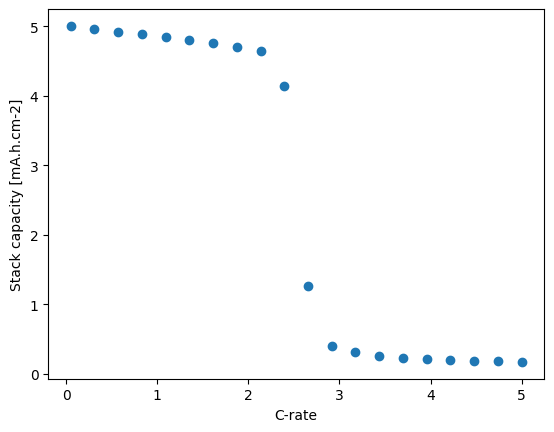

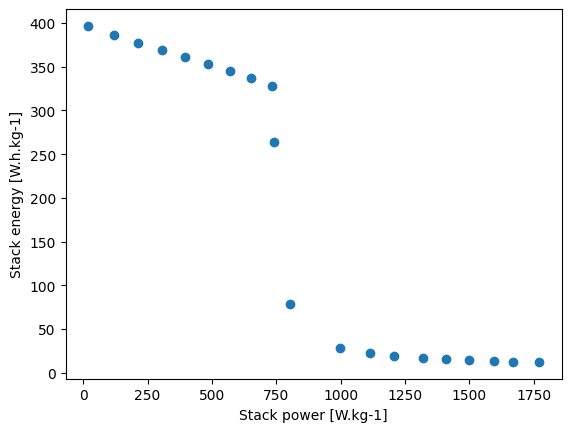

In [3]:
# set up the Ragone plot
C_rates = np.linspace(0.05, 5, 20)
capacities = np.zeros_like(C_rates)
currents = np.zeros_like(C_rates)
voltage_av = np.zeros_like(C_rates)

for i, C_rate in enumerate(C_rates):
    experiment = pybamm.Experiment(
        ["Discharge at {:.4f}C until 2.5V".format(C_rate)],
        period="{:.4f} seconds".format(10 / C_rate)
    )
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        solver=pybamm.CasadiSolver(dt_max=120),
        parameter_values=tea_class.parameter_values
    )
    sim.solve()

    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"]
    current = sim.solution["Current [A]"]
    voltage = sim.solution["Voltage [V]"]

    capacities[i] = capacity(time[-1])
    currents[i] = current(time[-1])
    voltage_av[i] = np.mean(voltage(time))

stack_thickness = tea_class.stack_energy["Stack thickness [m]"]
stack_density = tea_class.stack_energy["Stack density [kg.m-3]"]
stack_area = tea_class.parameter_values["Electrode height [m]"] * tea_class.parameter_values["Electrode width [m]"]

print("Gravimetric stack energy [W.h.kg-1]:", tea_class.stack_energy["Gravimetric stack energy [W.h.kg-1]"])
print("Gravimetric stack energy at C/20 [W.h.kg-1]:", capacities[0] * voltage_av[0] / stack_area / stack_thickness / stack_density)

plt.figure(1)
plt.scatter(C_rates, capacities / stack_area / 10) # 1000 mA.h.A.h-1 / 10000 cm2.m-2
plt.xlabel('C-rate')
plt.ylabel('Stack capacity [mA.h.cm-2]')

plt.figure(2)
plt.scatter(currents * voltage_av / stack_area / stack_thickness / stack_density, capacities * voltage_av / stack_area / stack_thickness / stack_density)
plt.xlabel('Stack power [W.kg-1]')
plt.ylabel('Stack energy [W.h.kg-1]')

plt.show()